In [3]:
# 전처리 과정
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.model_selection import train_test_split

# 경고 무시
warnings.filterwarnings('ignore')

#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 데이터 불러오기
df = pd.read_csv('../data/movie_info.csv')
df1 = pd.read_csv('../data/review-rating1.csv')
df2 = pd.read_csv('../data/review-rating2.csv')
df3 = pd.read_csv('../data/review-rating3.csv')
df4 = pd.read_csv('../data/review-rating4.csv')
df5 = pd.concat([df1, df2, df3, df4])
                                                    
# 결측치 제거
df5.dropna(inplace=True)

# 개봉일에서 제작연도만 빼내기
year_lis = []
for date in df['개봉일']:
    date_lis = []
    date_lis = date.split(".")
    if len(date_lis[0]) > 4:
        date_lis = date_lis[0].split("-")
    year_lis.append(date_lis[0])
df['제작연도'] = year_lis

# 두 데이터 프레임 합치기
df = pd.merge(df, df5, how='right', on='영화ID')

# 결측치 제거
df.dropna(subset=['누적매출액'], inplace=True)

# 정형 데이터만 뽑기
df = df[['제작연도', '누적매출액', '누적관객수', '스크린수', '상영횟수', '평균평점', '실제평점']]

# 데이터 타입 변경
df['제작연도'] = df['제작연도'].astype('int64')

# csv로 저장
df.to_csv("../data/review_info.csv", index=False)

# 데이터를 X, Y로 나누고 학습용, 검증용으로 나누기
train_cols = ['제작연도', '누적매출액', '누적관객수', '스크린수', '상영횟수', '평균평점']
X = df[train_cols]
y = df['실제평점']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler                                                                                                    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=0)),
    ])
params = {
    'clf__max_depth': list(range(3,9)),
    'clf__n_estimators': list(range(10,110,10)),
    }
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

{'clf__max_depth': 4, 'clf__n_estimators': 100}
0.4570460846300401


In [6]:
model = grid.best_estimator_['clf']
model.fit(X, y)

RandomForestClassifier(max_depth=4, random_state=0)

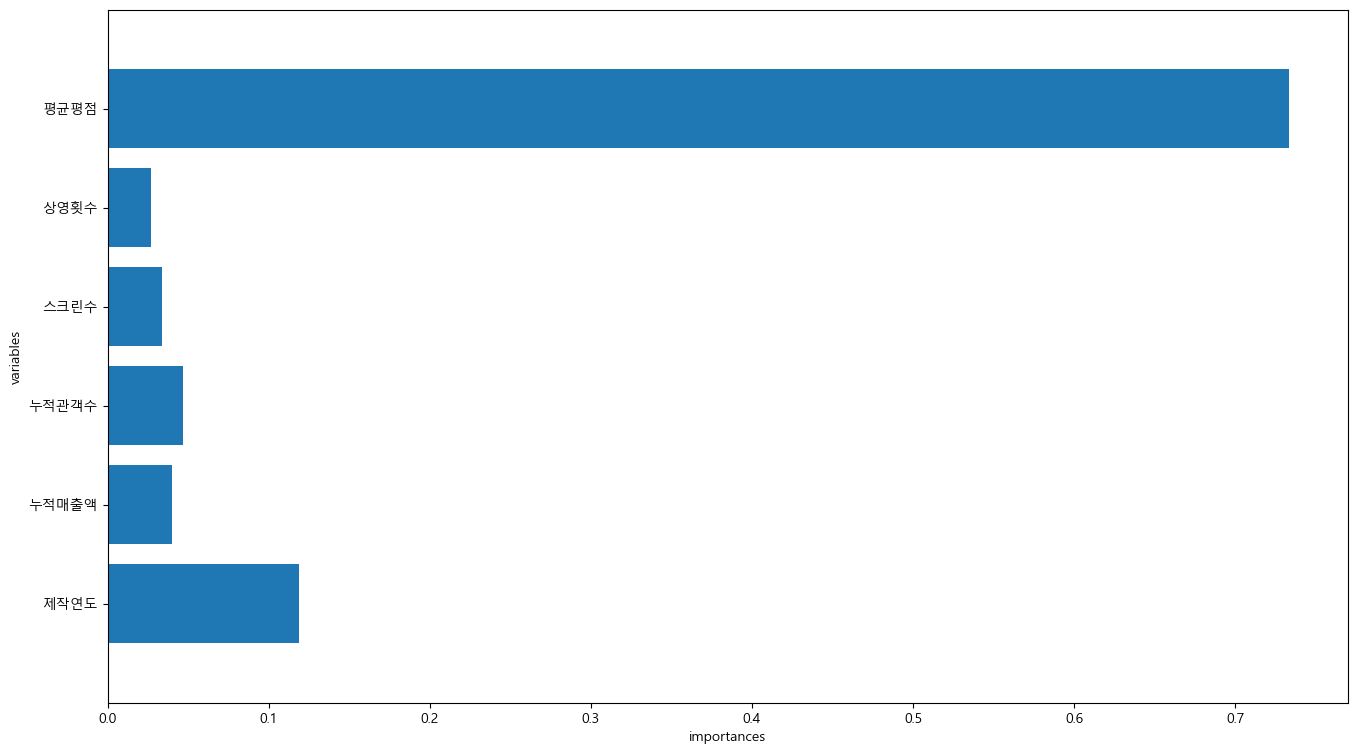

In [7]:
import numpy as np
def plot_tree(model):
    n_features = X.shape[1]
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train_cols)
    plt.xlabel("importances")
    plt.ylabel("variables")
    plt.ylim(-1, n_features)
plot_tree(model)

In [ ]:
# 최적의 파라미터로 모델 마무리
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# 모델 생성
model = models.Sequential()
model.add(layers.Dense(units=32, activation="relu", input_shape=(X_train.shape[1],), name="Hidden-1"))
model.add(layers.Dense(units=16, activation="relu", name="Hidden-2"))
model.add(layers.Dense(units=1, activation="linear", name="Output"))
model.compile(loss='mse', optimizer="rmsprop", metrics=["mse"])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_num.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_num.h5')
loaded_model.evaluate(X_test, y_test)

In [ ]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()